<a href="https://colab.research.google.com/github/wallykop/iad-deep-learning/blob/master/Kaggle_Jigsaw_Toxic_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re


from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

Работа с текстом - это одна из тех вещей, с которыми приходится сталкиваться каждому дата саентисту. Одна из самых популярных задач, свзяанных с текстом - классификация. Например, классифицировать email сообщения на наличие спама в них или неменее популярная постановка задачи - классфицировать репорты пользователей о продукте на негативные и положительные. 

Раньше на [kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) проходило соревнование связанное с класфикацией текстов по степени оскорбления в них. Метрика - площадь под roc-auc кривой

На данном семинаре мы попробуем обучить несложные (и более сложные) RNN.

Однако, прежде, чем обучать модели давайте посмотрим на данные:


In [0]:
!wget https://www.dropbox.com/s/o5y8x5138a5rh9j/train.csv.zip
!wget https://www.dropbox.com/s/wb1terxlw1z5k7d/test.csv.zip
!wget https://www.dropbox.com/s/6h3a6vrsm4laerc/test_labels.csv.zip

--2019-11-28 06:41:03--  https://www.dropbox.com/s/o5y8x5138a5rh9j/train.csv.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/o5y8x5138a5rh9j/train.csv.zip [following]
--2019-11-28 06:41:03--  https://www.dropbox.com/s/raw/o5y8x5138a5rh9j/train.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd1b6a470b18713a50ef0955131.dl.dropboxusercontent.com/cd/0/inline/AtM_dvBAW9stnkywiyHqoFDLR1UcJjvobCccs4uPMY74RqzfgyqmAOdmqAwV9pZSarZr7JSvEhLtHq25orGXSbkBEc_CkjBXbs5SZ6IYsX_JgSPv1dCTfI_GyvSnM6udIQ0/file# [following]
--2019-11-28 06:41:03--  https://ucd1b6a470b18713a50ef0955131.dl.dropboxusercontent.com/cd/0/inline/AtM_dvBAW9stnkywiyHqoFDLR1UcJjvobCccs4uPMY74RqzfgyqmAOdmqAwV9pZSarZr7JSvEhLtHq25orGXSbkBEc_CkjBXbs5SZ6IYsX_J

In [0]:
! unzip test_labels.csv.zip
! unzip test.csv.zip
! unzip train.csv.zip

Archive:  test_labels.csv.zip
replace test_labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
! ls

glove.42B.300d.zip  test.csv.zip     test_labels.csv.zip    train.csv.zip
sample_data	    test.csv.zip.1   test_labels.csv.zip.1  train.csv.zip.1
test.csv	    test_labels.csv  train.csv


In [0]:
x_train = pd.read_csv('./train.csv')
x_test = pd.read_csv('./test.csv')
y_test = pd.read_csv('./test_labels.csv')

In [0]:
print('Кол-во пропущенных значений в train: ', np.sum(x_train.comment_text.isnull()))
print('Кол-во пропущенных значений в test: ', np.sum(x_test.comment_text.isnull()))

Кол-во пропущенных значений в train:  0
Кол-во пропущенных значений в test:  0


In [0]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

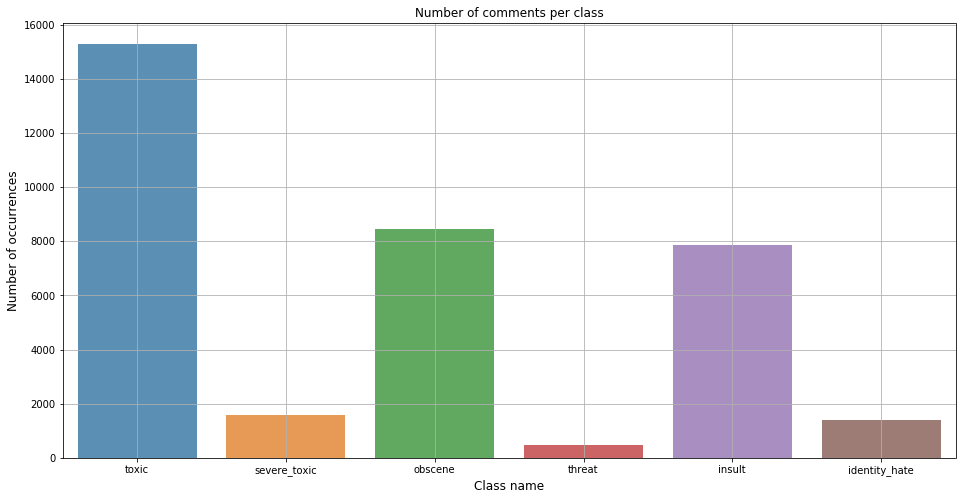

In [0]:
temp = x_train.loc[:,list_classes].sum()
plt.figure(figsize=(16, 8))
sns.barplot(temp.index, temp.values, alpha=0.8)
plt.title('Number of comments per class')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Class name', fontsize=12)
plt.grid(True)
plt.show()

Видно, что классы не сбалансированы, возможно с этим нужно будет что-то сделать. Предложите свои варианты

Так как в данной задаче для каждого объекта могут быть верными сразу несколько классов, то давайте посмотрим на гистограмму распределения количества меток между записями:

Text(0.5, 0, 'Number of classes')

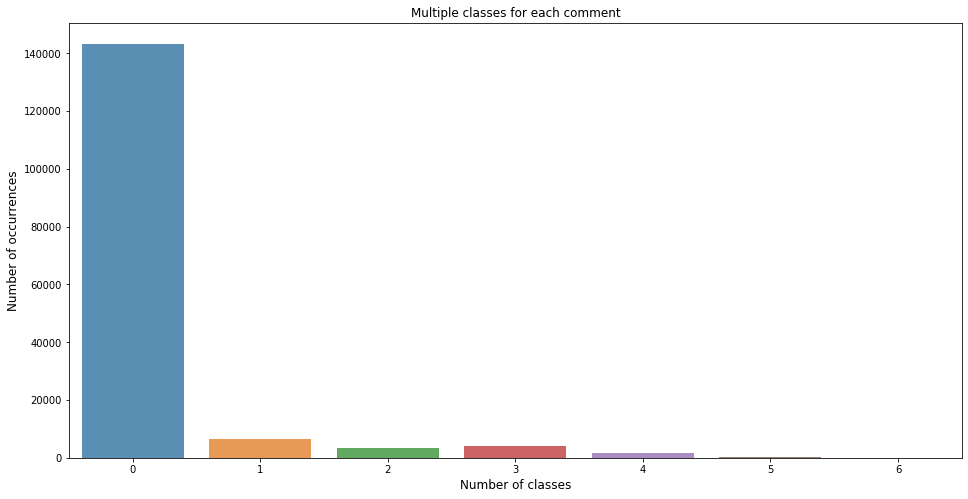

In [0]:
temp = x_train.loc[:,list_classes].sum(axis=1).value_counts()
plt.figure(figsize=(16,8))
ax = sns.barplot(temp.index, temp.values, alpha=0.8)
plt.title('Multiple classes for each comment')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Number of classes', fontsize=12)

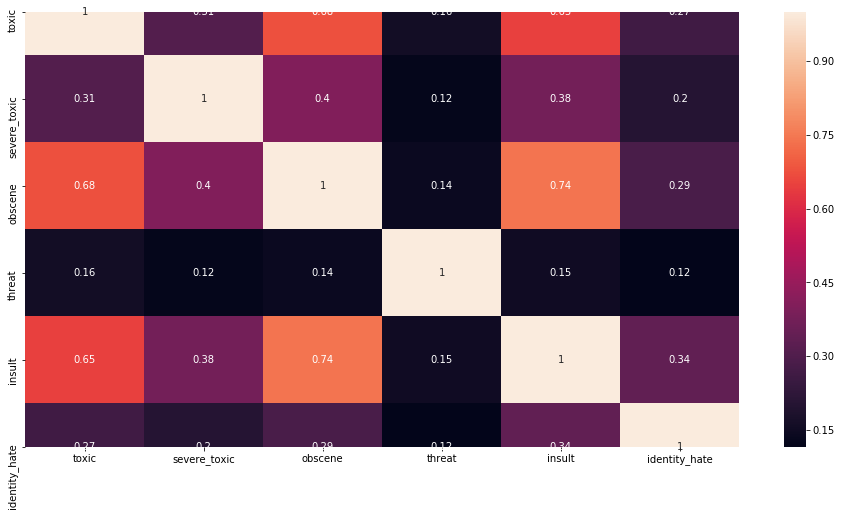

In [0]:
corr = x_train[list_classes].corr()
plt.figure(figsize = (16,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

Однако смотерть на корелляцию Пирсона для бинарных переменных не совсем корректно. Например, здесь не отображается одна из зависимостей, которую можно найти в распределении меток между комментариями. Предложите свои варианты как это сделать более правильно.
А пока давайте обратим внимание просто на название меток для классов. Рассмотрим severe_toxic и просто toxic они имеют почти похожую смысловую нагрузку. Предлагаю посмотреть зависят ли они друг от друга?

In [0]:
crosstab = pd.crosstab(x_train['toxic'], x_train['severe_toxic'])
crosstab

severe_toxic,0,1
toxic,,
0,144277,0
1,13699,1595


Зависимость видна сразу, если у объекта класс toxic == 0, то severe_toxic не может быть равным 1

После того, как мы получили какое-то представление о данных давайте попробуем придумать новые признаки и посмотрим на данные в разрезе новых фичей:

In [0]:
%%time 
#word count
x_train['count_word']=x_train["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
x_train['count_unique_word']=x_train["comment_text"].apply(lambda x: len(set(str(x).split())))
#Word count percent in each comment:
x_train['word_unique_percent']=x_train['count_unique_word']*100/x_train['count_word']
#derived features

CPU times: user 2.2 s, sys: 1.72 ms, total: 2.21 s
Wall time: 2.21 s


Давайте посмотрим на те комментарии, у которых количество уникальных слов удивительно мало:

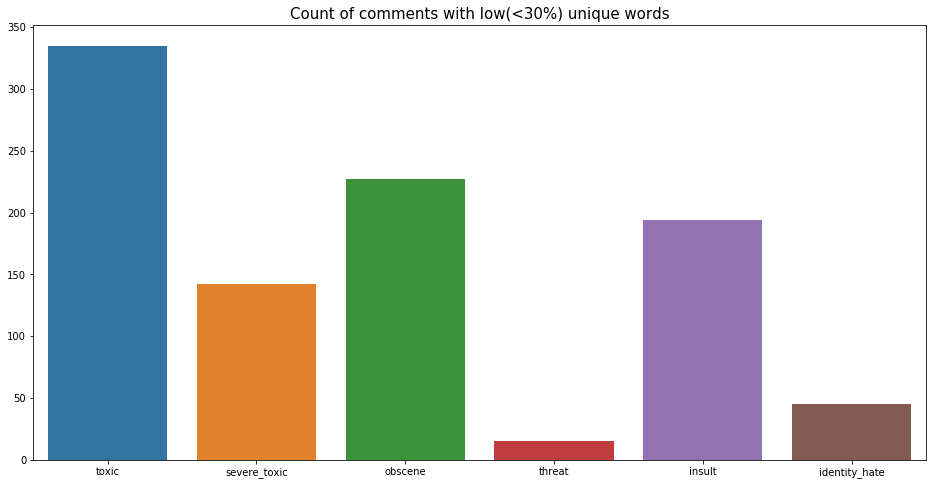

In [0]:
plt.figure(figsize = (16, 8))
temp = x_train.loc[x_train['word_unique_percent'] <= 30, list_classes].sum()
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x = temp.index, y = temp.values)

In [0]:
x_train.loc[x_train['word_unique_percent'] <= 30, 'comment_text'][1:3].values

array(['YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n\nI fucked your mum. OH WAIT YOUR GAY YOU DONT HAVE A MOM!!! HAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA\nLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOL\nCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTC

In [0]:
def delete_punctuation(x):
    punctuation = list(string.punctuation)
    return ''.join([a if a not in punctuation + ['\n'] else ' ' for a in x])

In [0]:
delete_punctuation('Explanation\nWhy the edits made under my usern.')

'Explanation Why the edits made under my usern '

In [0]:
# приведение всех слов к нижнему регистру
x_train['comment_text'] = x_train['comment_text'].apply(lambda x: x.lower())
x_test['comment_text'] = x_test['comment_text'].apply(lambda x: x.lower())
# удаление пунктуации
x_train['comment_text'] = x_train['comment_text'].apply(delete_punctuation)
x_test['comment_text'] = x_test['comment_text'].apply(delete_punctuation)

В качестве начального приближения давайте возьмем только униграмы и обучим логистичскую регрессию для каждого класса:

In [0]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip

--2019-11-28 06:45:10--  http://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip [following]
--2019-11-28 06:45:10--  https://nlp.stanford.edu/data/wordvecs/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.42B.300d.zip [following]
--2019-11-28 06:45:11--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Le

Перейдем к нейросетям:

In [0]:
from keras.layers import Dense, Input, GRU, Embedding, Dropout, Bidirectional
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

In [0]:
import os, zipfile
file_name = os.path.abspath('./glove.42B.300d.zip') # get full path of files
zip_ref = zipfile.ZipFile(file_name) # create zipfile object
zip_ref.extractall('./') # extract file to dir
zip_ref.close() # close file
os.remove(file_name) # delete zipped file

In [0]:
f = open('./glove.42B.300d.txt')

embeddings_index = dict() 
for line in tqdm_notebook(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Ada-Gram, Sergey Bartunov

In [0]:
embed_size = 300 # how big is each word vector
max_features = 100000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 150 # max number of words in a comment to use

list_sentences_train = x_train["comment_text"].values
y = x_train[list_classes].values
list_sentences_test = x_test["comment_text"].values

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
x_train_pad = pad_sequences(list_tokenized_train, maxlen=maxlen)
x_test_pad = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
emb_mean, emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.005720101, 0.2951066)

In [0]:
word_index = tokenizer.word_index
unknown_words = set()
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    else: unknown_words.add(word)

In [0]:
from keras.layers import Embedding

In [0]:
input_layer = Input((maxlen,), name = 'comment_text')
embedding_layer = Embedding(max_features, embed_size, input_length=maxlen, 
                            weights=[embedding_matrix], 
                            trainable = False)(input_layer)
x = Bidirectional(GRU(128, return_sequences=True))(embedding_layer)
x = Dropout(0.3)(x)
x = Bidirectional(GRU(128, return_sequences=False))(x)
x = Dense(64, activation="relu")(x)
output_layer = Dense(6, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(clipvalue=1, clipnorm=1),
                  metrics=['accuracy'])
print(model.summary())

def schedule(ind):
    a = [0.001, 0.001, 0.0001, 0.0001, 0.00001, 0.00001, 0.000001]
    return a[ind]

lr = LearningRateScheduler(schedule)
    
early_stop = EarlyStopping(monitor='val_loss',
                           patience=4,
                           verbose=1,
                           min_delta=1e-4)


history = model.fit(x_train_pad, y, batch_size=256, epochs = 7, 
                    validation_split = 0.1, verbose = 1, callbacks = [lr])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comment_text (InputLayer)    (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          30000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 256)          329472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               295680    
____________________________________

KeyboardInterrupt: ignored

Что можно еще сделать?

1. LSTM

   --hidden units
   
   --layers
     
2. Ensembling 
   
   --log reg + nn + gb
   
   --cosine lr

3. Convolutions for texts

4. Attention (coming soon)

5. Char RNN

6. LR scheduling (for, example cosine)

7. [ROC-AUC trick](https://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml04.icdm06long.pdf) 

8. Combining features (texts + table data)

9. Augmentation
